In [61]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import sasc.viz
from sasc import analyze_helper
from sasc.modules.fmri_module import convert_module_num_to_voxel_num
from sasc.config import FMRI_DIR, RESULTS_DIR
import dvu
dvu.set_style()

# pcs = joblib.load(join(FMRI_DIR, "voxel_neighbors_and_pcs", "loo_pc_UTS02.pkl"))
# pcs['good_voxels'].shape
# pcs['pca_projections'].shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
# pilot_name = 'pilot_story_data.pkl'
pilot_name = 'pilot3_story_data.pkl'

stories_data_dict = joblib.load(
    join(sasc.config.RESULTS_DIR, pilot_name))
if pilot_name == 'pilot_story_data.pkl':
    pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20230504'
elif pilot_name == 'pilot3_story_data.pkl':
    pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20231106'

In [63]:
# load responses
default_story_idxs = np.where(
    np.array(stories_data_dict['story_setting']) == 'default')[0]
resp_np_files = [stories_data_dict['story_name_new'][i].replace('_resps', '')
                 for i in default_story_idxs]
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}


mats = defaultdict(list)
if 'pilot3' in pilot_name:
    use_clusters_list = [False]
else:
    use_clusters_list = [False, True]
for use_clusters in use_clusters_list:
    for story_num in default_story_idxs:
        rows = stories_data_dict["rows"][story_num]

        # get resp_chunks
        resp_story = resps_dict[
            stories_data_dict["story_name_new"][story_num].replace(
                '_resps', '')
        ].T  # (voxels, time)
        timing = stories_data_dict["timing"][story_num]
        if 'paragraphs' in stories_data_dict.keys():
            paragraphs = stories_data_dict["paragraphs"][story_num]
        else:
            paragraphs = stories_data_dict["story_text"][story_num].split(
                "\n\n")
        # paragraphs = stories_data_dict["story_text"][story_num].split("\n\n")
        if pilot_name in ['pilot3_story_data.pkl']:
            paragraphs = [sasc.analyze_helper.remove_repeated_words(
                p) for p in paragraphs]
        assert len(paragraphs) == len(
            rows), f"{len(paragraphs)} != {len(rows)}"
        resp_chunks = analyze_helper.get_resps_for_paragraphs(
            timing, paragraphs, resp_story, offset=2)
        assert len(resp_chunks) <= len(paragraphs)

        # calculate mat
        mat = np.zeros((len(rows), len(paragraphs)))
        for i in range(len(resp_chunks)):
            if use_clusters == False:
                mat[:, i] = resp_chunks[i][rows["voxel_num"].values].mean(
                    axis=1)
            elif use_clusters == True:
                for r in range(len(rows)):
                    cluster_nums = rows.iloc[r]["cluster_nums"]
                    if isinstance(cluster_nums, np.ndarray):
                        vals = resp_chunks[i][cluster_nums].flatten()
                        mat[r, i] = np.nanmean(vals)
                    else:
                        # print(cluster_nums)
                        mat[r, i] = np.nan
        mat[:, 0] = np.nan  # ignore the first column
        # print('mat', mat)

        # sort by voxel_num
        args = np.argsort(rows["voxel_num"].values)
        mat = mat[args, :][:, args]
        mats[use_clusters].append(deepcopy(mat))

        # plt.imshow(mat)
        # plt.colorbar(label="Mean response")
        # plt.xlabel("Corresponding paragraph\n(Ideally, diagonal should be brighter)")
        # plt.ylabel("Voxel")
        # plt.title(f"{story_data['story_name_new'][story_num][3:-10]}")
        # plt.show()
rows = rows.sort_values(by="voxel_num")
expls = rows["expl"].values


m = {}
for use_clusters in [False, True]:
    mats[use_clusters] = np.array(mats[use_clusters])  # (6, 17, 17)
    m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:12<00:00,  6.21s/it]
/tmp/ipykernel_2933454/2698880625.py:78: RuntimeWarning: Mean of empty slice
  m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)


### Make average plot

mean 0.12076091786792413


['/home/chansingh/automated-explanations/results/processed/pilot3_default_means.pkl']

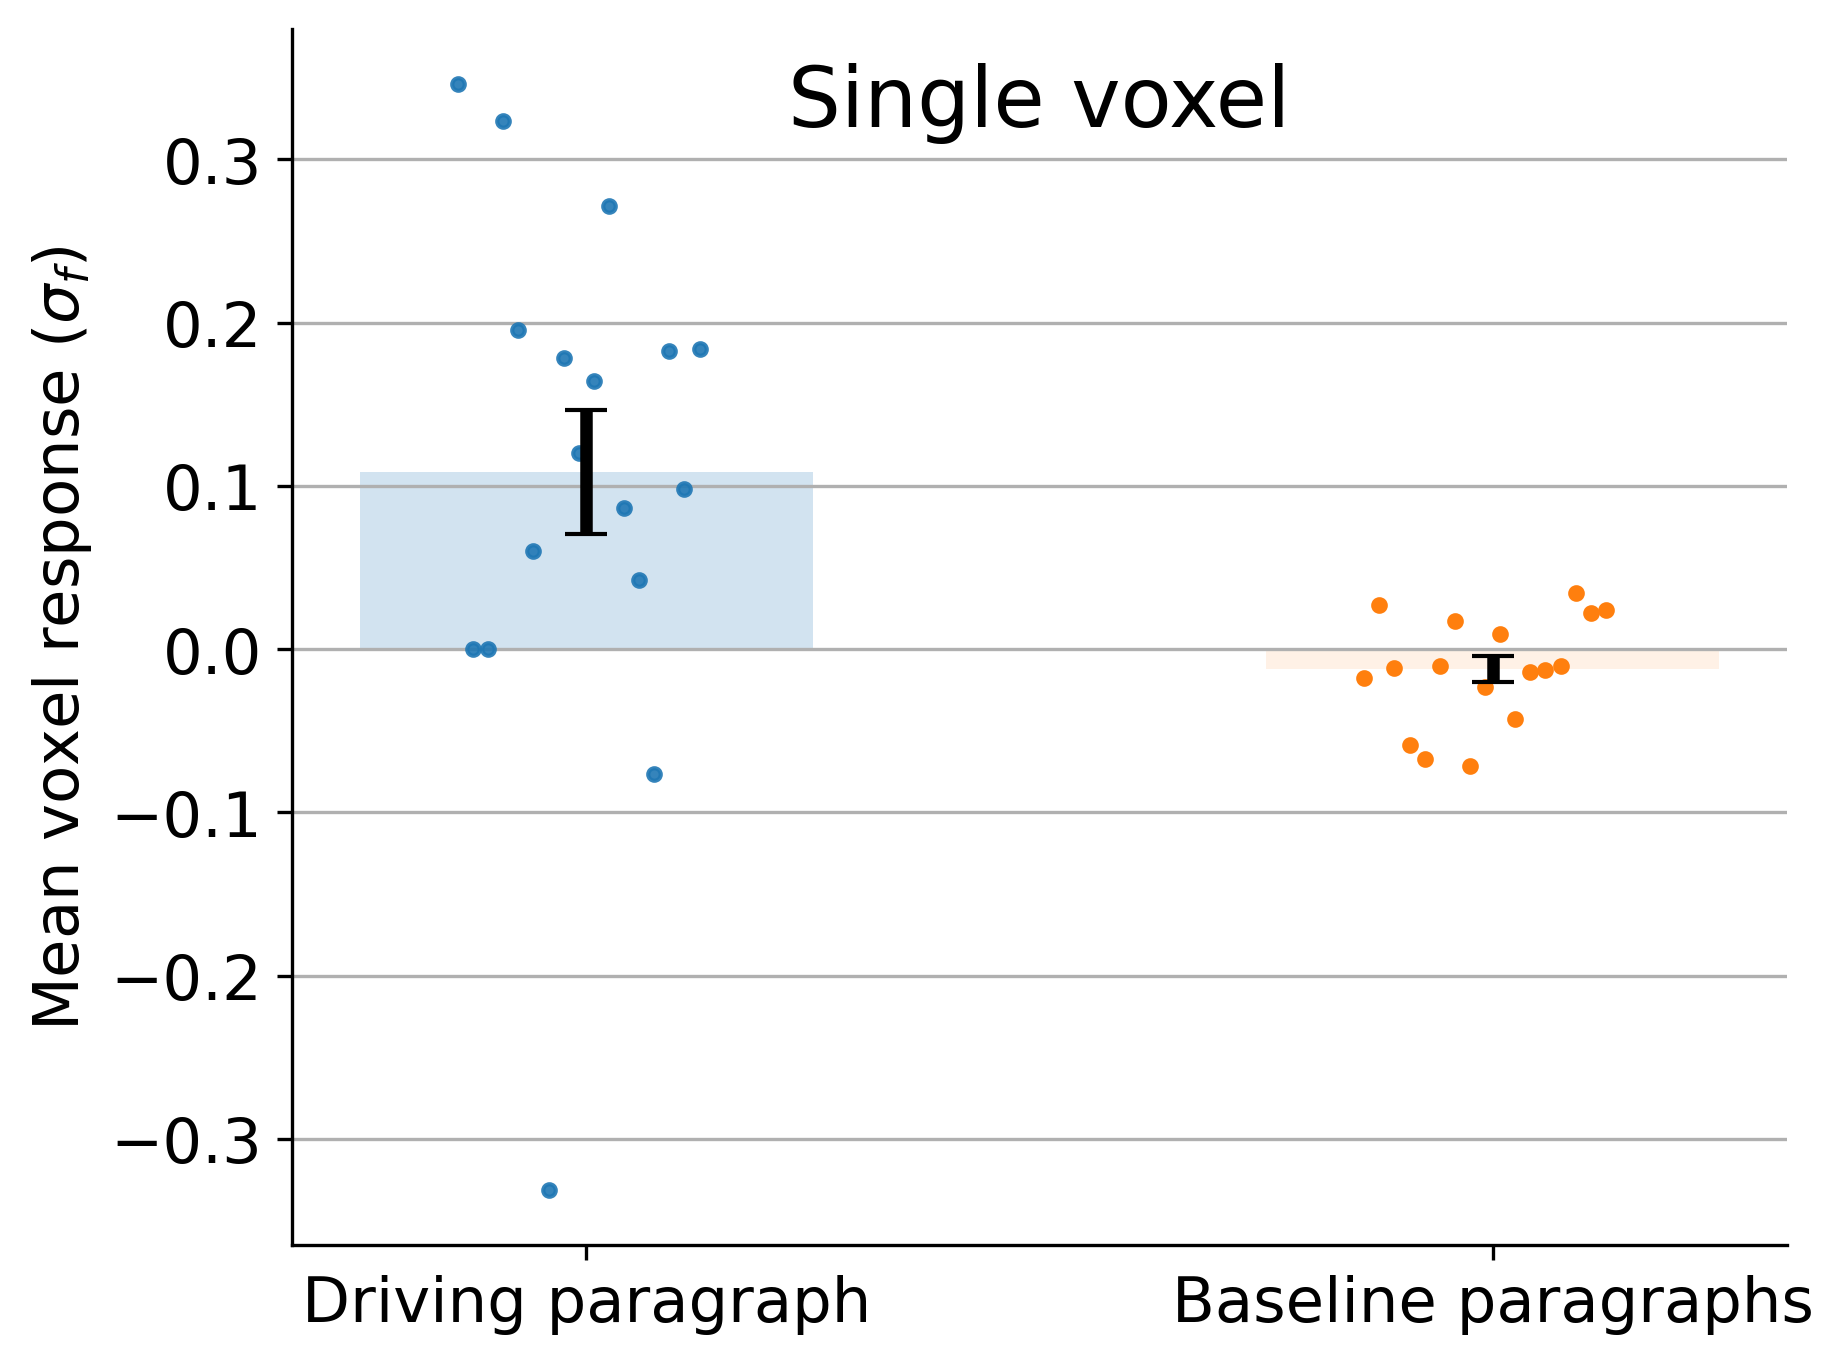

In [64]:
# calculate means
use_clusters = False
m1 = m[use_clusters]
diag_means = np.diag(m1)
off_diag_means = np.nanmean(m1, axis=1) - (diag_means / len(diag_means))
sasc.viz.barplot_default([diag_means], [off_diag_means],
                         pilot_name, expls, annot_points=False)
joblib.dump({'diag_means': diag_means,
            'off_diag_means': off_diag_means}, join(RESULTS_DIR, 'processed', pilot_name.replace('_story_data.pkl', '_default_means.pkl')))

### Relationship between different voxels

In [54]:
# note: some voxels didn't have good clusters so they will be missing from these plots...
use_clusters = False
m1 = m[use_clusters]

# cg = sns.clustermap(pd.DataFrame(m, columns=expls, index=expls), method='complete', cmap='viridis', figsize=(10, 10))
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.xlabel('Driving paragraph')
# plt.figure(figsize=(6, 4), dpi=300)
# m = softmax(m, axis=0)

sasc.viz.outline_diagonal(m1.shape, color='black', lw=1, block_size=1)


expls_order = analyze_helper.sort_expls_semantically(expls)
m_plot = m1[expls_order][:, expls_order]  # [:, expls_order]
# m_plot = m1
sasc.viz.imshow_diverging(m_plot)
plt.xlabel("Driving paragraph\n(Ideally, diagonal should be brighter)",
           fontsize='x-small')
plt.ylabel("Voxel", fontsize='x-small')
plt.yticks(labels=expls[expls_order], ticks=np.arange(
    len(expls)), fontsize='x-small')
plt.xticks(labels=expls[expls_order], ticks=np.arange(
    len(expls)), rotation=90, fontsize='x-small')
plt.tight_layout()
plt.savefig(join(RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_default_heatmap.pdf'))
plt.show()
# plot correlations across all resps
# resps_voxels = np.concatenate(
#     [resps_dict[story_data["story_name_new"][story_num]].T for story_num in [2, 3, 4]],
#     axis=1,
# )[rw["voxel_num"].values]
# corr = pd.DataFrame(resps_voxels.T, columns=expls).corr().round(2)
# sns.clustermap(corr)

100%|██████████| 17/17 [00:00<00:00, 91.15it/s]


IndexError: index 13 is out of bounds for axis 0 with size 0

### Story-level differences

<>:18: DeprecationWarning: invalid escape sequence '\s'
<>:18: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_2933454/2013272243.py:18: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel('Mean voxel response ($\sigma_f$)')


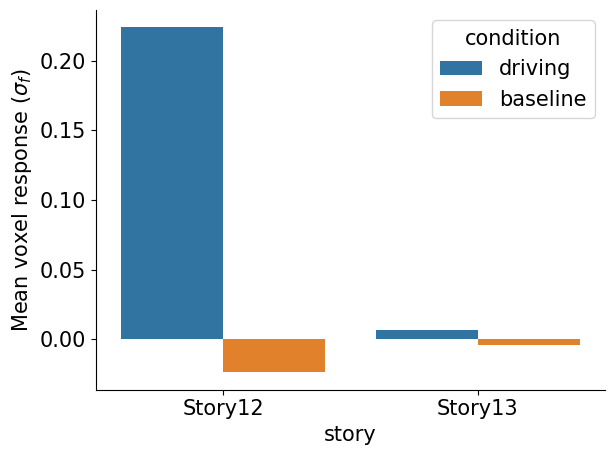

In [44]:
use_clusters = False
mats1 = mats[use_clusters]

d = defaultdict(list)
for i in range(len(mats1)):
    m = mats1[i]
    d['driving'].append(np.nanmean(np.diag(m)))
    d['baseline'].append(np.nanmean(m[~np.eye(m.shape[0], dtype=bool)]))
    d['story'].append(stories_data_dict['story_name_new'][i][3:-10])

df = pd.DataFrame.from_dict(d)

# make barplot comparing driving and baseline
df = df.melt(id_vars='story', value_vars=[
             'driving', 'baseline'], var_name='condition', value_name='mean')
df = df.sort_values(by='story')
sns.barplot(data=df, x='story', y='mean', hue='condition')
plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.savefig(join(RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_default_story_breakdown.pdf'))
plt.show()

### Make combined average plot

mean 0.19103979716530367


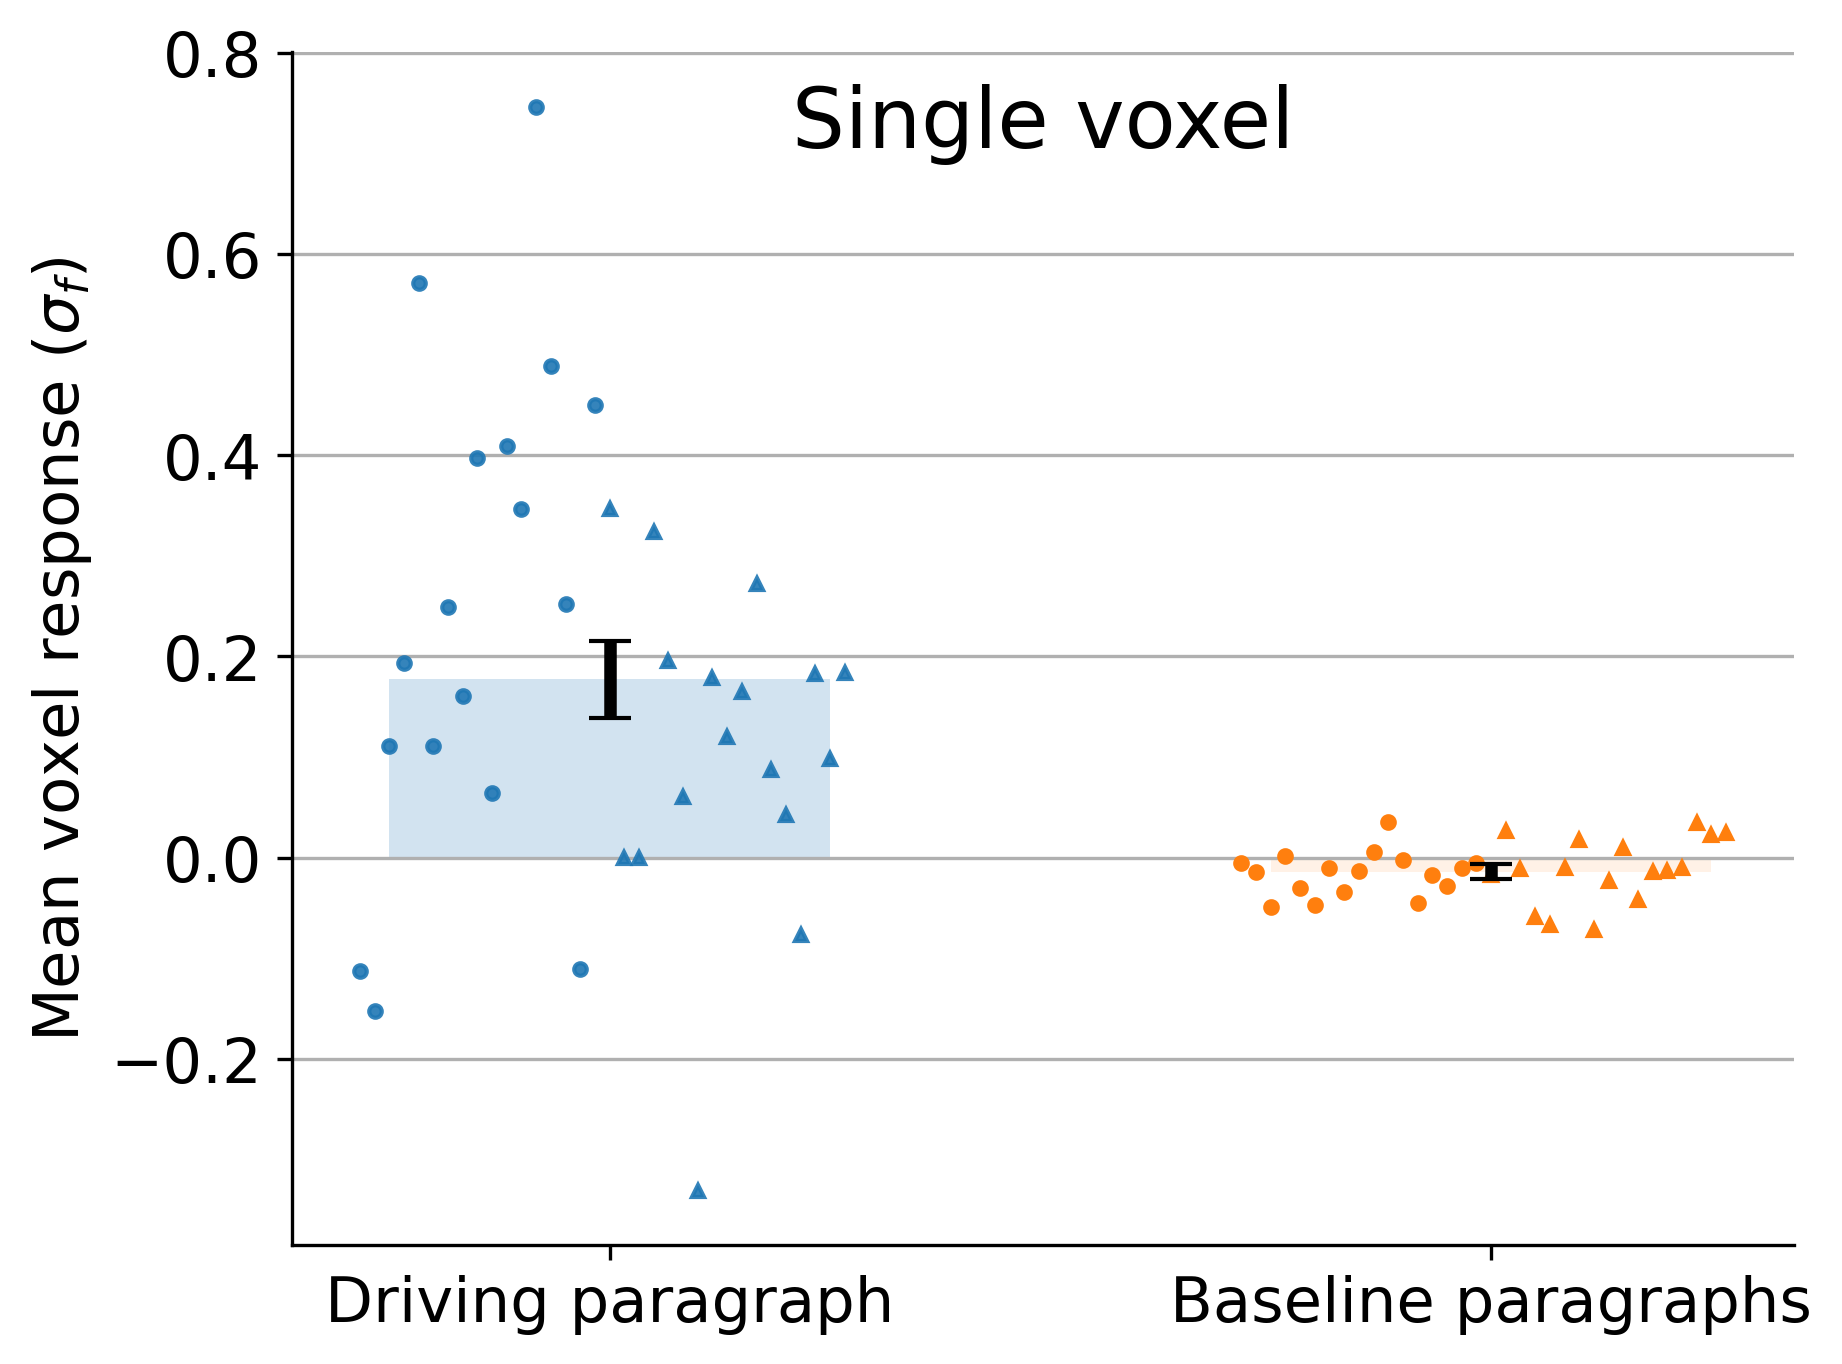

In [45]:
uts02 = joblib.load(join(RESULTS_DIR, 'processed', 'pilot_default_means.pkl'))
uts03 = joblib.load(join(RESULTS_DIR, 'processed', 'pilot3_default_means.pkl'))
sasc.viz.barplot_default([uts02['diag_means'], uts03['diag_means']],
                         [uts02['off_diag_means'], uts03['off_diag_means']],
                         pilot_name='full_', expls=[], annot_points=False)

### Voxel-level differences

/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


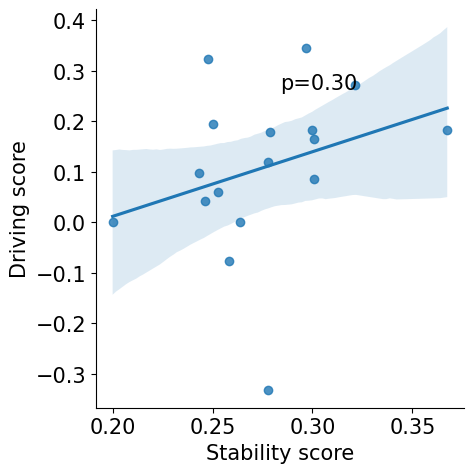

In [67]:
# add stats
rows["driving_score"] = np.diag(m[False])
rm = pd.read_pickle(join(RESULTS_DIR, 'sasc', "fmri_results_merged.pkl")).sort_values(
    by=["stability_score"], ascending=False
)
for k in ["fmri_test_corr_llama", "top_score_normalized_llama"]:
    rows[k] = rows.apply(
        lambda row: rm[
            (rm.module_num == row.module_num) & (rm.subject == row.subject)
        ].iloc[0][k],
        axis=1,
    ).values


# make plot
cols = [
    "driving_score",
    "stability_score",
    "top_score_normalized",
    "top_score_normalized_llama",
    "fmri_test_corr",
    "fmri_test_corr_llama",
]
sns.lmplot(data=rows, x="stability_score", y="driving_score")
plt.text(
    0.5,
    0.8,
    f"p={rows[cols].corr().loc['stability_score', 'driving_score']:.2f}",
    transform=plt.gca().transAxes,
)
plt.ylabel("Driving score")
plt.xlabel("Stability score")
plt.savefig(join(RESULTS_DIR, 'figs/misc',
            pilot_name[:pilot_name.index('_')] + '_stability_score.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
sns.pairplot(rows[cols + ["expl"]], kind="reg")  # , hue='expl')